In [1]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from anndata import AnnData
from natsort import natsorted

# Customized packages
import starmap.sc_util as su
# test()

In [2]:
##Set path
base_path = ''

input_path = os.path.join(base_path, 'input')

out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

sc.settings.figdir = fig_path

In [3]:
# load combined file
adata = sc.read_h5ad(os.path.join(out_path, '2024-01-21-Nectow-Lab-combined-3mad-filtered.h5ad'))
adata

AnnData object with n_obs × n_vars = 85072 × 256
    obs: 'sample', 'area', 'protocol', 'x', 'y', 'seg_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'n_genes', 'n_counts', 'protocol-sample'
    var: 'max_counts_sample1_STARmap', 'max_counts_sample2_STARmap', 'max_counts_sample3_STARmap', 'max_counts_sample4_STARmap', 'max_counts_sample5_RIBOmap', 'max_counts_sample6_RIBOmap', 'max_counts_sample7_RIBOmap', 'max_counts_sample8_RIBOmap'
    layers: 'raw'

In [4]:
#Filtering gene list
#Used only starmap data here

thres = 2
passed = (adata.var['max_counts_sample1_STARmap'] > thres) & (adata.var['max_counts_sample2_STARmap'] > thres) & (adata.var['max_counts_sample3_STARmap'] > thres) & (adata.var['max_counts_sample4_STARmap'] > thres) # four STARmap samples

print(adata.var.loc[passed, :].shape[0])

adata.var['detected'] = passed
adata.var['highly_variable'] = passed

250


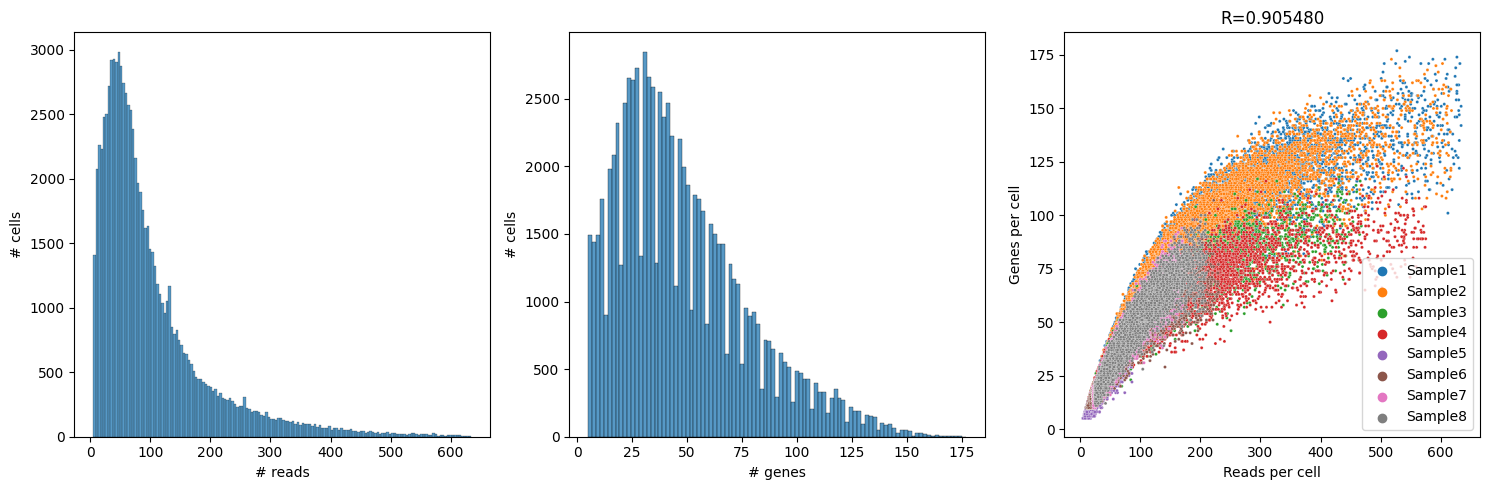

In [5]:
# Per-cell Stats Plot
su.plot_stats_per_cell(adata, color='sample')

In [6]:
# Get quantiles of reads
su.show_reads_quantile(adata)

Reads per cell quantile:
0.10     22.0
0.25     41.0
0.50     72.0
0.75    130.0
0.90    224.0
Name: total_counts, dtype: float64


In [7]:
# Normalization scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.raw = adata

In [8]:
# Scale data to unit variance and zero mean
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X.copy()

In [9]:
# Regress out unwanted variance 
sc.pp.regress_out(adata, ['total_counts'])
adata.layers['corrected'] = adata.X.copy()

In [10]:
# Combat (only for the dataset with all eight sections)
sc.pp.combat(adata, 'protocol-sample')
adata.layers['combat'] = adata.X.copy()

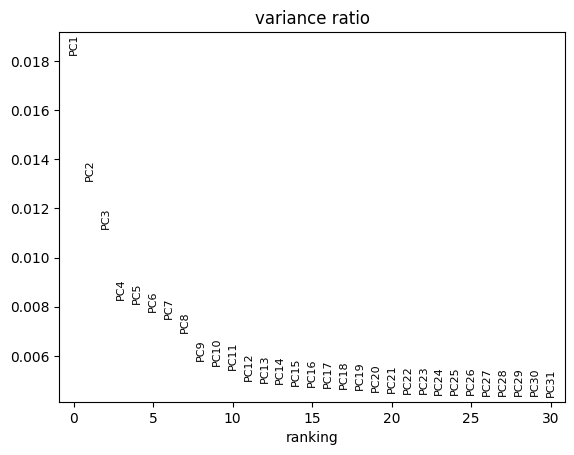

In [11]:
# Run PCA
sc.tl.pca(adata, svd_solver='full', use_highly_variable=True)

# Plot explained variance 
sc.pl.pca_variance_ratio(adata, log=False)

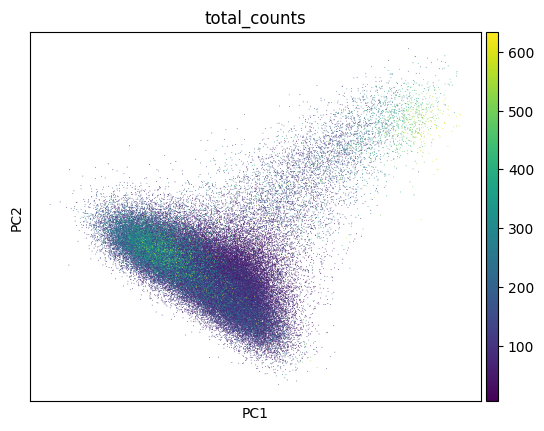

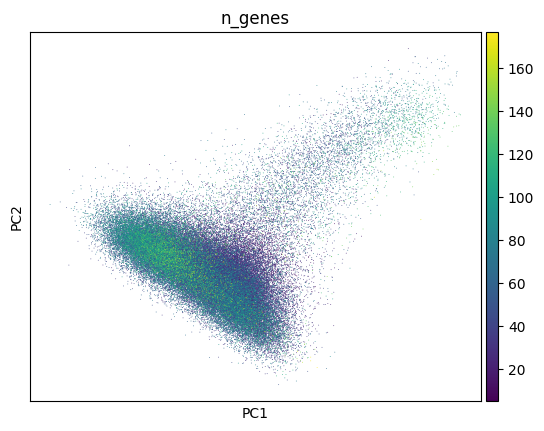

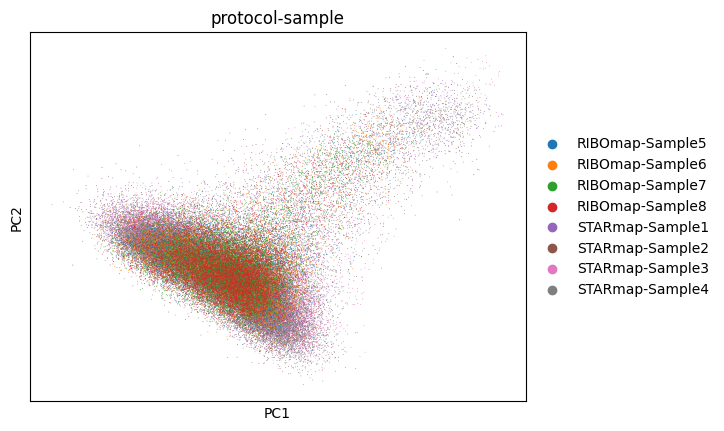

In [12]:
# Plot PCA
sc.pl.pca(adata, color='total_counts')
sc.pl.pca(adata, color='n_genes')
sc.pl.pca(adata, color='protocol-sample')

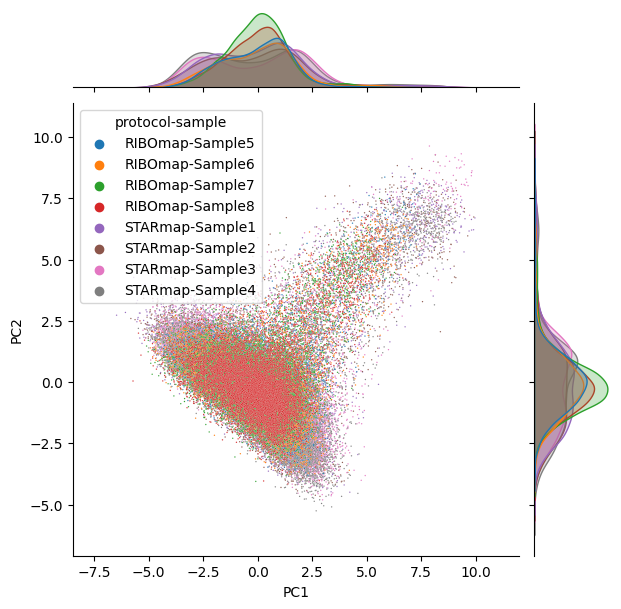

In [13]:
g = sns.jointplot(x=adata.obsm['X_pca'][:, 0], y=adata.obsm['X_pca'][:, 1], hue=adata.obs['protocol-sample'],
                 s=1)
g.set_axis_labels('PC1', 'PC2')
plt.show()

In [14]:
%%time

import scanpy.external as sce

sce.pp.harmony_integrate(adata, 'protocol-sample')

2025-01-31 13:34:55,494 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-31 13:35:22,043 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-31 13:35:22,704 - harmonypy - INFO - Iteration 1 of 10
2025-01-31 13:35:59,285 - harmonypy - INFO - Iteration 2 of 10
2025-01-31 13:36:31,123 - harmonypy - INFO - Iteration 3 of 10
2025-01-31 13:36:43,338 - harmonypy - INFO - Iteration 4 of 10
2025-01-31 13:36:55,477 - harmonypy - INFO - Converged after 4 iterations


CPU times: user 5min 10s, sys: 1min 36s, total: 6min 46s
Wall time: 2min 2s


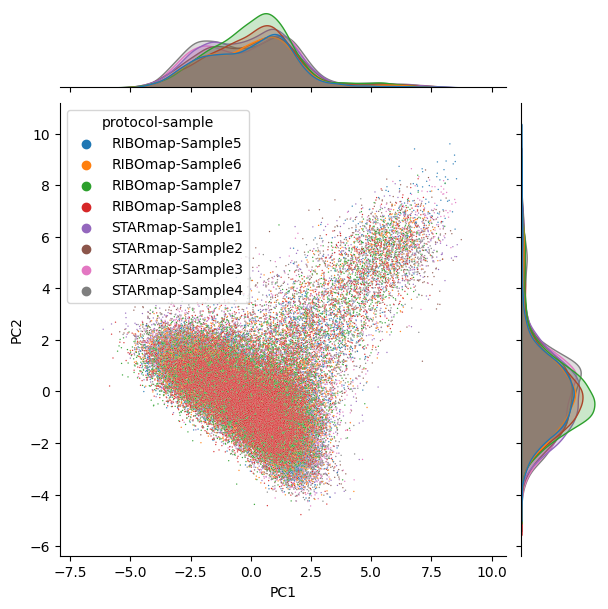

In [15]:
g = sns.jointplot(x=adata.obsm['X_pca_harmony'][:, 0], y=adata.obsm['X_pca_harmony'][:, 1], hue=adata.obs['protocol-sample'],
                 s=1)
g.set_axis_labels('PC1', 'PC2')
plt.show()

In [16]:
%%time
# Computing the neighborhood graph
n_neighbors = 50
n_pcs = 50
    
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep='X_pca_harmony')

# Run UMAP
sc.tl.umap(adata, min_dist=.0001, spread=5, random_state = 0)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 5min 8s, sys: 11.4 s, total: 5min 19s
Wall time: 3min 44s


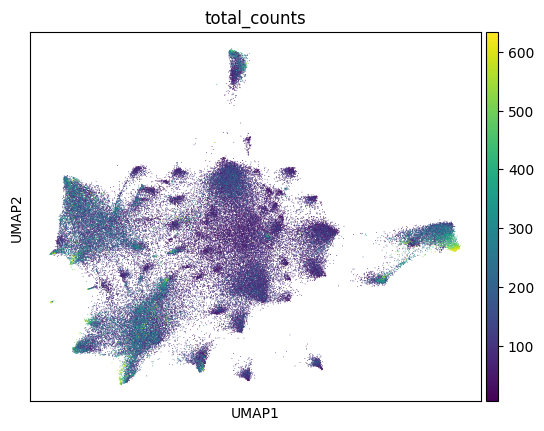

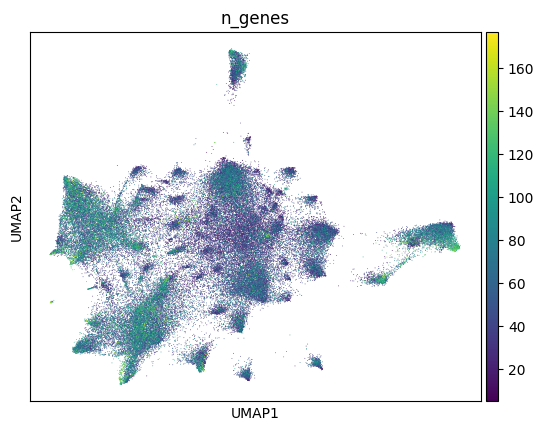

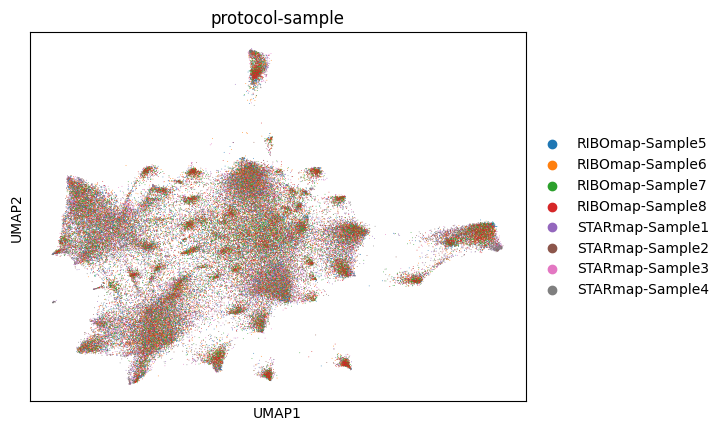

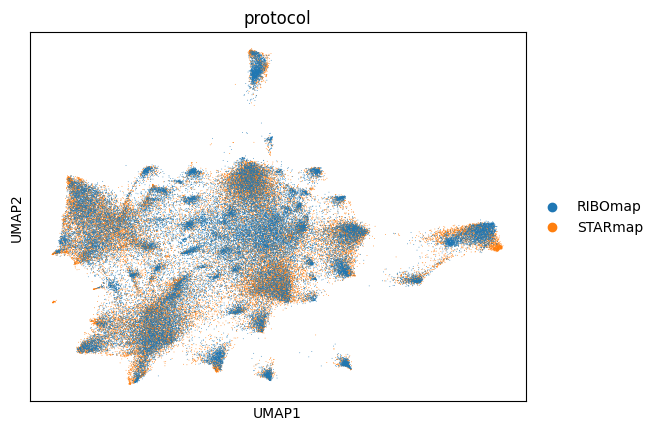

In [17]:
sc.pl.umap(adata, color='total_counts')
sc.pl.umap(adata, color='n_genes')
sc.pl.umap(adata, color='protocol-sample')
sc.pl.umap(adata, color='protocol')

In [18]:
# save integrated h5ad
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
# adata.write_h5ad(f"{out_path}/{date}-Brain-RIBOmap-harmony.h5ad")
adata.write_h5ad(f"{out_path}/{date}-Nectow-Lab-combined-HARMONY.h5ad")